**Setup for visualizers**

The notebook loads a cohort of patients with mutations in *SUOX*, performs the functional variant annotation, and collates the data into a `Cohort` object.

In [1]:
%matplotlib inline

import os
import hpotk

hpotk.util.setup_logging()

# Setup resources


## Load HPO

Use HPO release *2023-10-09*. The ontology is downloaded from the PURL.

> Note: feel free to download the file once and provide the local path, e.g. `/home/joe/path/to/hp.json`.

In [2]:
fpath_hpo = 'https://github.com/obophenotype/human-phenotype-ontology/releases/download/v2023-10-09/hp.json'

hpo = hpotk.load_minimal_ontology(fpath_hpo)
hpo.version

'2023-10-09'

# Load samples

## Configure patient creator

Patient creator transforms phenopackets into `Patient`s - the internal representation of the sample data. 

The transformation includes checking that the phenotypic features -  the uses HPO to check all phenotypic features are annotated with current HPO terms 

### Setup phenotypic feature validation

We ensure that the phenotypic features of the subjects meet the following validation requirements:
- the phenotypic features are represented using current (non-obsolete) HPO term IDs
- all phenotypic features are descendants of *Phenotypic abnormality* branch of HPO
- the terms do not violate the annotation propagation rule - subjects are not annotated by a term and its ancestor/descendant

In [3]:
from hpotk.validate import ValidationRunner
from hpotk.validate import ObsoleteTermIdsValidator, PhenotypicAbnormalityValidator, AnnotationPropagationValidator

validation_runner = ValidationRunner(
    validators=(
        ObsoleteTermIdsValidator(hpo),
        PhenotypicAbnormalityValidator(hpo),
        AnnotationPropagationValidator(hpo)
        ))

In [4]:
from genophenocorr.preprocessing import configure_caching_patient_creator

pc = configure_caching_patient_creator(hpo, validation_runner=validation_runner)

## Load phenopackets

Walk the directory, find all JSON files, load them into phenopackets, and transform the phenopackets to patients.

> Note: the first run takes longer since we must reach out to VEP REST API. However, the subsequent runs use data that we cache in `.genophenocorr_cache` folder next to this notebook.

In [5]:
from genophenocorr.preprocessing import load_phenopacket_folder

fpath_suox_cohort = os.path.join(os.getcwd(), os.pardir, 'notebooks', 'SUOX', 'phenopackets')
cohort = load_phenopacket_folder(fpath_suox_cohort, pc)
f'Loaded {len(cohort)} samples'

Patients Created: 100%|██████████| 35/35 [00:00<00:00, 511.48it/s]


'Loaded 35 samples'

# Gather data for visualization

Here we get the data required for visualizing the variants on selected transcript or protein.

## Choose the transcript

We need to choose the transcript and protein IDs - currently this is done manually but we will find a way how to do this automatically, e.g. using MANE transcript.

The MANE Select transcript for *SUOX* is [NM_001032386.2](https://www.genenames.org/data/gene-symbol-report/#!/hgnc_id/HGNC:11460) and the corresponding protein accession ID is `NP_001027558.1`.

In [6]:
tx_id = 'NM_001032386.2'
protein_id = 'NP_001027558.1'

## Gather the data for visualization

We need to get:
- variants
- transcript coordinates
- protein metadata

### Variants

Variants are easy, `Cohort` exposes all the variants via the `all_variants` property:

In [7]:
variants = cohort.all_variants
len(variants)

48

In [8]:
next(iter(variants))

Variant(variant_coordinates:VariantCoordinates(region=GenomicRegion(contig=12, start=56003672, end=56003673, strand=+), ref=G, alt=GC, change_length=1), tx_annotations:(TranscriptAnnotation(gene_id:SUOX,transcript_id:NM_000456.3,hgvsc_id:NM_000456.3:c.287dup,is_preferred:False,variant_effects:(<VariantEffect.FRAMESHIFT_VARIANT: 'SO:0001589'>,),overlapping_exons:(6,),protein_affected:(ProteinMetadata(id=NP_000447.2, label=Sulfite oxidase, mitochondrial, features=(SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=Cytochrome b5 heme-binding, start=82, end=161)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Hinge, start=165, end=174)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Moco domain, start=175, end=401)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Homodimerization, start=402, end=538)))),),protein_effect_location:Region(start=94, end=95)), TranscriptAnnotation(gene_id:SUOX,transcript_id:NM_001

### Transcript coordinates

Transcript coordinates can be fetched from Variant Validator API:

In [9]:
from genophenocorr.model.genome import GRCh38
from genophenocorr.preprocessing import VVTranscriptCoordinateService

txc_service = VVTranscriptCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(tx_id)
tx_coordinates

TranscriptCoordinates(identifier=NM_001032386.2, region=GenomicRegion(contig=12, start=55997275, end=56005525, strand=+))

The `TranscriptCoordinates` object knows about the number of coding bases and aminoacid codons. 

Note, the counts of coding bases and codons do *not* include the termination codon.

In [10]:
print(f'{tx_id} has {tx_coordinates.get_coding_base_count():,} coding bases')
print(f'{tx_id} has {tx_coordinates.get_codon_count():,} codons')

NM_001032386.2 has 1,635 coding bases
NM_001032386.2 has 545 codons


We can get the UTR regions (both 5' and 3') as well as the CDS regions.

Note, for simplicity, the CDS regions include *both* initiation and termination codons!

5' UTR regions:

In [11]:
for utr in tx_coordinates.get_five_prime_utrs():
    print(f'{utr.start:,}-{utr.end:,}')

55,997,275-55,997,339
55,997,614-55,997,723
56,002,211-56,002,221


CDS regions:

In [12]:
for cds in tx_coordinates.get_cds_regions():
    print(f'{cds.start:,}-{cds.end:,}')

56,002,221-56,002,271
56,002,542-56,002,720
56,003,617-56,005,027


3' UTR regions

In [13]:
for utr in tx_coordinates.get_three_prime_utrs():
    print(f'{utr.start:,}-{utr.end:,}')

56,005,027-56,005,525


### Protein metadata

Last, we fetch the protein metadata from Uniprot.

The significance of the warning that is logged is unclear to me at this time. We need to investigate.

In [14]:
from genophenocorr.preprocessing import UniprotProteinMetadataService

pms = UniprotProteinMetadataService()

protein_metas = pms.annotate(protein_id)

assert len(protein_metas) == 1
protein_meta = protein_metas[0]
protein_meta

ProteinMetadata(id=NP_001027558.1, label=Sulfite oxidase, mitochondrial, features=(SimpleProteinFeature(type=FeatureType.DOMAIN, info=FeatureInfo(name=Cytochrome b5 heme-binding, start=82, end=161)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Hinge, start=165, end=174)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Moco domain, start=175, end=401)), SimpleProteinFeature(type=FeatureType.REGION, info=FeatureInfo(name=Homodimerization, start=402, end=538))))

We get metadata with 4 features (1 domain and 3 regions), which is in line with the Uniprot [Family & Domains section](https://www.uniprot.org/uniprotkb/P51687/entry#family_and_domains).

In [15]:
for feature in protein_meta.protein_features:
    print(f'name: {feature.info.name}, type: {feature.feature_type}, start: {feature.info.start}, end: {feature.info.end}, ')

name: Cytochrome b5 heme-binding, type: FeatureType.DOMAIN, start: 82, end: 161, 
name: Hinge, type: FeatureType.REGION, start: 165, end: 174, 
name: Moco domain, type: FeatureType.REGION, start: 175, end: 401, 
name: Homodimerization, type: FeatureType.REGION, start: 402, end: 538, 


# Visualize the data

### Draw the figures

Now, let's draw the plots:

In [16]:
from genophenocorr.view import VariantTranscriptVisualizer

viz = VariantTranscriptVisualizer()

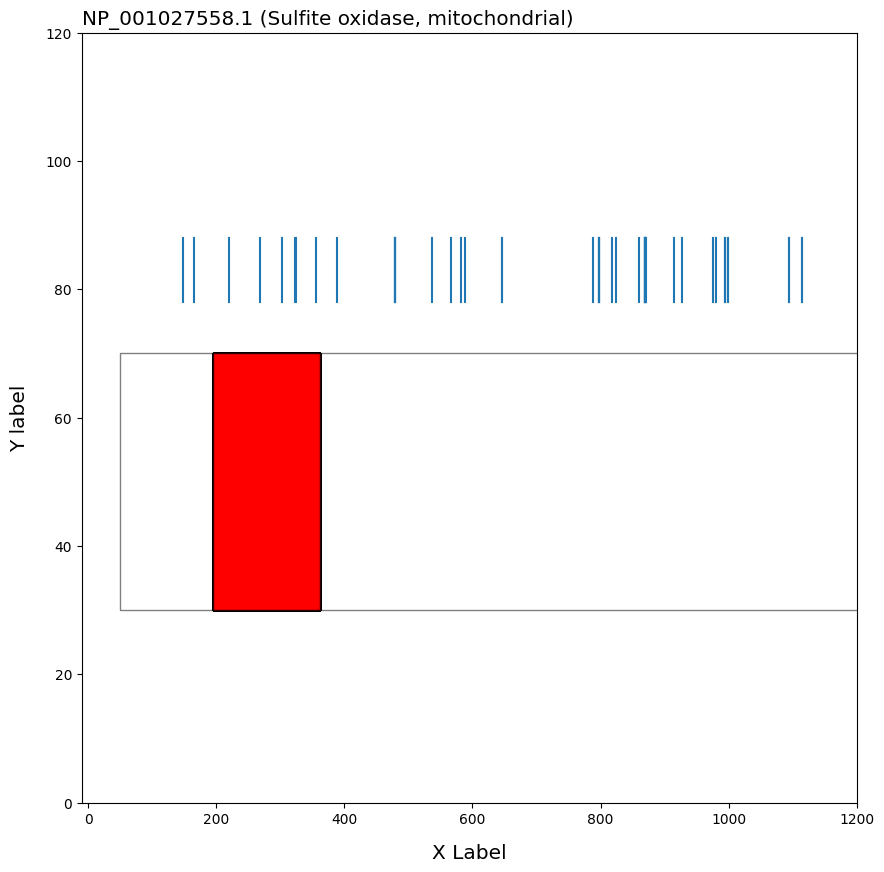

In [17]:
viz.draw_variants(variants, tx_coordinates, protein_meta)

### TODO - implement